# DE reproducibility in union mode

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pandas as pd

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

import anndata
import scanpy as sc

from scipy.stats import pearsonr, spearmanr

from scvi import set_seed

import copy

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

In [3]:
set_seed(1)

In [4]:
# Load anndata
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")

# Filter out unanalyzed clusters
include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in anndataset_111.obs["leiden_subclusters"]
]
# anndataset_111 = anndataset_111[include_cells]


# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
)

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]

# Organize and instantiate scVI dataset
hvg_111 = anndataset_111.var["hvg_encode"]

batches = anndataset_111.obs["batch_indices"].values.ravel()
ad_d1 = anndataset_111[:, hvg_111][batches==0]
ad_d2 = anndataset_111[:, hvg_111][batches==1]
ad_d2.obs["batch_indices"] -= 1

dataset_111_d1 = AnnDatasetFromAnnData(ad=ad_d1)
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111[batches==0].obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111_d1.initialize_cell_measurement(protein_data_111)
dataset_111_d1.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_111_d2 = AnnDatasetFromAnnData(ad=ad_d2)
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=ad_d2.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111_d2.initialize_cell_measurement(protein_data_111)
dataset_111_d2.gene_names = anndataset_111[:, hvg_111].var_names.values

Trying to set attribute `.obs` of view, making a copy.


[2020-04-28 21:10:36,881] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 21:10:36,884] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 21:10:36,947] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 21:10:37,012] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells
[2020-04-28 21:10:37,620] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 21:10:37,623] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 21:10:37,683] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 21:10:37,735] INFO - scvi.dataset.dataset | Downsampled from 7564 to 7564 cells


### Setup joint datasets

In [5]:
dataset_out = GeneExpressionDataset()
# Protein panels intersected
dataset_out.populate_from_datasets(
    [dataset_111_d1, dataset_111_d2],
)

dataset_in = copy.deepcopy(dataset_out)

held_out_proteins = dataset_out.protein_expression[
    dataset_out.batch_indices.ravel() == 1
].copy()

dataset_out.protein_expression[dataset_out.batch_indices.ravel() == 1] = np.zeros_like(
    dataset_out.protein_expression[dataset_out.batch_indices.ravel() == 1]
)
batch_mask = dataset_out.get_batch_mask_cell_measurement("protein_expression")

[2020-04-28 21:10:38,232] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-04-28 21:10:38,369] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 21:10:38,467] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 21:10:38,469] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 21:10:38,578] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 21:10:38,659] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 21:10:38,661] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 21:10:39,016] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 21:10:39,018] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 21:10:39,029] INFO - scvi.dataset.dataset | Keeping 110 columns in protein_expression


### Setup held out model

In [6]:
model_out = TOTALVI(
    dataset_out.nb_genes,
    dataset_out.protein_expression.shape[1],
    n_latent=20,
    n_batch=dataset_out.n_batches,
    encoder_batch=True,
    protein_batch_mask=batch_mask,
)

use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer_out = TotalTrainer(
    model_out,
    dataset_out,
    train_size=0.9,
    test_size=0.1,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory":False},
    early_stopping_kwargs=early_stopping_kwargs,
    use_adversarial_loss=True,
    kappa=None
)

### Setup held in model

In [7]:
model_in = TOTALVI(
    dataset_in.nb_genes,
    dataset_in.protein_expression.shape[1],
    n_latent=20,
    n_batch=dataset_in.n_batches,
    encoder_batch=True,
)

use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer_in = TotalTrainer(
    model_in,
    dataset_in,
    train_size=0.9,
    test_size=0.1,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory":False},
    early_stopping_kwargs=early_stopping_kwargs,
)

### Train models

In [8]:
trainer_out.train(lr=lr, n_epochs=500)
trainer_in.train(lr=lr, n_epochs=500)

[2020-04-28 21:26:04,282] INFO - scvi.inference.trainer | Reducing LR on epoch 232.
[2020-04-28 21:29:12,615] INFO - scvi.inference.trainer | Reducing LR on epoch 292.
[2020-04-28 21:29:59,807] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-04-28 21:29:59,809] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


[2020-04-28 21:46:53,555] INFO - scvi.inference.trainer | Reducing LR on epoch 331.
[2020-04-28 21:48:43,335] INFO - scvi.inference.trainer | Reducing LR on epoch 367.
[2020-04-28 21:50:48,154] INFO - scvi.inference.trainer | Reducing LR on epoch 408.
[2020-04-28 21:52:53,025] INFO - scvi.inference.trainer | Reducing LR on epoch 449.
[2020-04-28 21:54:52,062] INFO - scvi.inference.trainer | Reducing LR on epoch 488.



### Create poseteriors

In [9]:
# create posterior on full data
full_posterior_out = trainer_out.create_posterior(
    model_out, dataset_out, indices=np.arange(len(dataset_out)), type_class=TotalPosterior
)
full_posterior_in = trainer_in.create_posterior(
    model_in, dataset_in, indices=np.arange(len(dataset_in)), type_class=TotalPosterior
)

# Run one vs all DE

In [10]:
# Call scvi function
dataset_out_bi_old = dataset_out.batch_indices.copy()
dataset_out.batch_indices = np.zeros_like(dataset_out.batch_indices)
per_cluster_de_out_list, cluster_id_out = full_posterior_out.one_vs_all_degenes(
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    subset=include_cells,
    delta=0.2,
    mode="change",
    use_observed_batches=True,
)
per_cluster_de_out = {}
for i, c in enumerate(cluster_id_out):
    per_cluster_de_out[c] = per_cluster_de_out_list[i]

In [11]:
dataset_in_bi_old = dataset_in.batch_indices.copy()
dataset_in.batch_indices = np.zeros_like(dataset_in.batch_indices)
per_cluster_de_in_list, cluster_id_in = full_posterior_in.one_vs_all_degenes(
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    subset=include_cells,
    delta=0.2,
    mode="change",
    use_observed_batches=True, 
)
per_cluster_de_in = {}
for i, c in enumerate(cluster_id_in):
    per_cluster_de_in[c] = per_cluster_de_in_list[i]

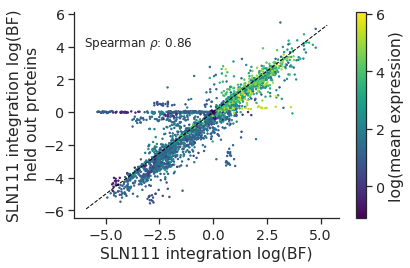

In [16]:
fig, ax = plt.subplots(1, 1)

avg_exp = np.log(
    np.mean(dataset_in.protein_expression[dataset_in.batch_indices.ravel() == 0, :], axis=0)
)

xs, ys = [], []
for c in per_cluster_de_out.keys():
    #     t1 = np.sum(np.array(dataset_111_d1.cell_types)[dataset_111_d1.labels] == c) < 10
    #     t2 = np.sum(np.array(dataset_111_d2.cell_types)[dataset_111_d2.labels] == c) < 10
    #     if not (t1 or t2):
    pro_rows = per_cluster_de_out[c].index.str.contains("ADT_")
    total_temp = per_cluster_de_out[c].iloc[pro_rows]

    pro_rows = per_cluster_de_in[c].index.str.contains("ADT_")
    bg_temp = per_cluster_de_in[c].iloc[pro_rows]

    df = pd.DataFrame(index=bg_temp.index)
    df["SLN111 integration log(BF)"] = bg_temp["bayes_factor"].values
    total_temp = total_temp.loc[df.index]
    df["SLN111 integration log(BF) held out proteins"] = total_temp["bayes_factor"]

    xs.append(df["SLN111 integration log(BF)"].values.ravel())
    ys.append(df["SLN111 integration log(BF) held out proteins"].values.ravel())
    
    ae = pd.DataFrame(avg_exp)
    ae.index = dataset_in.protein_names
    ae = ae.loc[df.index]

    a = ax.scatter(
        df["SLN111 integration log(BF)"],
        df["SLN111 integration log(BF) held out proteins"],
        c=ae.values.ravel(),
        s=2,
        cmap='viridis'
    )

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c="black", linestyle="--", lw=1)

cbar = plt.colorbar(a)
cbar.set_label("log(mean expression)")

xs = np.concatenate(xs)
ys = np.concatenate(ys)
rho = np.round(spearmanr(xs, ys)[0], 2)
ax.text(-6, 4, r"Spearman $\rho$: {}".format(rho), fontsize=12)
plt.xlabel("SLN111 integration log(BF)")
plt.ylabel("SLN111 integration log(BF)\n held out proteins")
sns.despine()
plt.tight_layout()
fig.savefig("figures/union_mode_de_reproducibility.pdf")

In [13]:
c = "Mature B"
pro_rows = per_cluster_de_out[c].index.str.contains("ADT_")
total_temp = per_cluster_de_out[c].iloc[pro_rows]

pro_rows = per_cluster_de_in[c].index.str.contains("ADT_")
bg_temp = per_cluster_de_in[c].iloc[pro_rows]

df = pd.DataFrame(index=bg_temp.index)
df["SLN111 integration log(BF)"] = bg_temp["bayes_factor"].values
total_temp = total_temp.loc[df.index]
df["SLN111 integration log(BF) held out proteins"] = total_temp["bayes_factor"]

In [14]:
total_temp[np.abs(total_temp["bayes_factor"]) < 0.5].iloc[:50]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
ADT_I-A-I-E_A0117,0.5798,0.4202,0.321952,108.396751,94.085083,0.614287,0.000000,6.128555,-9.138794,9.104374,...,8.841805,-8.911629,8.968800,194.285736,69.868103,0.531609,0.571251,NaN,NaN,Mature B
ADT_CD29_A0570,0.5574,0.4426,0.230617,9.703648,20.192930,-0.366303,0.000000,4.109184,-9.048445,8.060221,...,6.369307,-8.739325,6.698904,7.861895,15.380197,0.531220,0.573449,NaN,NaN,Mature B
ADT_CD28_A0204,0.5998,0.4002,0.404632,0.558024,4.861606,-2.336673,-3.613795,1.961495,-5.815132,5.558302,...,0.000000,-4.660536,0.000000,1.857226,3.324859,0.512546,0.565325,NaN,NaN,Mature B
ADT_CD134(OX-40)_A0195,0.4222,0.5778,-0.313749,10.594732,11.858514,-0.147471,-0.123892,0.313900,-4.812118,4.374115,...,0.422206,-1.340332,0.619036,5.400895,6.574692,0.531609,0.573449,NaN,NaN,Mature B
ADT_CD117(c-Kit)_A0012,0.6058,0.3942,0.429691,0.632602,4.417144,-2.141993,-3.354245,1.866449,-7.437540,6.229921,...,0.000000,-6.699619,0.000000,1.570317,3.071872,0.499125,0.556341,NaN,NaN,Mature B
ADT_CD73_A0077,0.5500,0.4500,0.200671,0.889460,12.521621,-2.824305,-4.578122,2.763392,-7.929006,6.719101,...,0.000000,-7.901629,0.366798,1.327368,8.146325,0.471504,0.548313,NaN,NaN,Mature B
ADT_CD127(IL-7Ra)_A0198,0.6032,0.3968,0.418816,0.528448,2.972859,-1.888298,-2.864632,1.588142,-4.465994,3.807900,...,0.000000,-4.016340,0.000000,0.597938,1.679824,0.356156,0.486763,NaN,NaN,Mature B
ADT_CD62P(P-selectin)_A0229,0.4342,0.5658,-0.264735,3.952936,1.500492,1.243540,0.000000,2.420205,-5.714593,4.919584,...,4.391121,-4.748931,4.651255,3.900214,3.837427,0.530442,0.571633,NaN,NaN,Mature B
ADT_CD90.1(Thy-1.1)_A0380,0.4938,0.5062,-0.024801,0.668921,0.673881,-0.010386,0.000000,0.592974,-0.940034,0.948931,...,0.878886,-0.913297,0.894681,0.210076,0.224028,0.163587,0.178343,NaN,NaN,Mature B
ADT_CX3CR1_A0563,0.4876,0.5124,-0.049610,0.849883,0.878930,-0.048423,0.000000,1.007925,-1.599320,1.605569,...,1.500219,-1.548340,1.541790,0.378720,0.505687,0.262206,0.289592,NaN,NaN,Mature B


In [15]:
idx = total_temp[np.abs(total_temp["bayes_factor"]) < 0.5].index

bg_temp.loc[idx].iloc[:50]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
ADT_I-A-I-E_A0117,0.9484,0.0516,2.911254,359.412201,107.824326,5.578402,8.723740,4.326273,-2.383739,11.127416,...,10.492452,-1.541927,10.737717,381.418793,124.968559,1.000000,0.996177,NaN,NaN,Mature B
ADT_CD29_A0570,0.7738,0.2262,1.229894,12.136591,22.432697,0.514871,0.000000,3.827898,-9.560549,8.322662,...,6.118198,-8.350363,6.678998,16.776892,32.565517,0.999611,0.999522,NaN,NaN,Mature B
ADT_CD28_A0204,0.6284,0.3716,0.525359,0.543378,5.055762,-2.442184,-3.588447,1.929161,-5.090173,4.894921,...,0.000000,-4.763599,0.000000,3.446022,5.921055,0.962459,0.984326,NaN,NaN,Mature B
ADT_CD134(OX-40)_A0195,0.6246,0.3754,0.509119,2.588489,8.472997,-2.115406,-4.380959,2.908248,-6.660895,5.567968,...,4.943977,-6.029118,5.150166,9.539584,10.955749,0.999805,0.999713,NaN,NaN,Mature B
ADT_CD117(c-Kit)_A0012,0.6068,0.3932,0.433881,0.569579,4.700861,-2.195587,-3.360940,1.889317,-8.175905,4.902103,...,0.000000,-6.806737,0.119153,2.879984,6.093759,0.932114,0.969129,NaN,NaN,Mature B
ADT_CD73_A0077,0.5784,0.4216,0.316209,0.629074,13.609481,-2.991269,-4.366336,2.691607,-8.385828,6.536343,...,0.000000,-7.948464,0.000000,2.695974,15.518016,0.899047,0.962343,NaN,NaN,Mature B
ADT_CD127(IL-7Ra)_A0198,0.5780,0.4220,0.314569,0.508098,2.899318,-1.821765,-2.744025,1.596306,-5.119459,4.169990,...,0.000000,-4.006830,0.000000,1.142579,3.278123,0.675744,0.853962,NaN,NaN,Mature B
ADT_CD62P(P-selectin)_A0229,0.5762,0.4238,0.307193,5.244519,1.917521,1.691152,0.038322,2.567066,-5.690528,4.757718,...,4.483242,-4.597291,4.678071,6.946314,6.388703,0.997471,0.995126,NaN,NaN,Mature B
ADT_CD90.1(Thy-1.1)_A0380,0.5044,0.4956,0.017600,0.730480,0.688060,0.090156,0.000000,0.592909,-0.896255,0.909145,...,0.870171,-0.877856,0.884835,0.375608,0.377425,0.303832,0.303641,NaN,NaN,Mature B
ADT_CX3CR1_A0563,0.4904,0.5096,-0.038405,0.922040,0.928821,-0.011209,0.000000,1.014774,-1.633994,1.627547,...,1.496452,-1.540062,1.535394,0.709395,0.935869,0.490761,0.504253,NaN,NaN,Mature B
